### Data Wrangling - Duplicate Transactions

You will notice a number of what look like duplicated transactions in the data set. One type of duplicated transaction is a reversed transaction, where a purchase is followed by a reversal. Another example is a multi-swipe, where a vendor accidentally charges a customer's card multiple times within a short time span.

programmatically identify reversed and multi-swipe transactions and total number of transactions and total dollar amount estimate for the reversed transactions. For the multi-swipe transactions? (consider the first transaction to be "normal" and exclude it from the number of transaction and dollar amount counts)

### Predictive Model To Find The Fraud Transaction

Fraud is a problem for any bank. Fraud can take many forms, whether it is someone stealing a single credit card, to large batches of stolen credit card numbers being used on the web, or even a mass compromise of credit card numbers stolen from a merchant via tools like credit card skimming devices.
build a predictive model to determine whether a given transaction will be fraudulent or not.
[Dataset can be download here](https://github.com/CapitalOneRecruiting/DS) and it has over 8 lahs transactions.

**Author :** Krishnakanth Yachareni

In [9]:
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec

# Load the 500MB transactions it has over 8 lakh transactions.
with zipfile.ZipFile("transactions.zip") as z:
   with z.open("transactions.txt") as f:
      data = pd.read_json(f, lines=True)
pd.set_option('display.max_columns', None)

In [10]:
data.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,,0.0,,,,False,,,False,False
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,True,,,False,False
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,False,,,False,False
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,False,,,False,False
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,,0.0,,,,True,,,False,False


In [11]:
# Print the shape of the data
print(data.describe())

       accountNumber    customerId    creditLimit  availableMoney  \
count   7.863630e+05  7.863630e+05  786363.000000   786363.000000   
mean    5.372326e+08  5.372326e+08   10759.464459     6250.725369   
std     2.554211e+08  2.554211e+08   11636.174890     8880.783989   
min     1.000881e+08  1.000881e+08     250.000000    -1005.630000   
25%     3.301333e+08  3.301333e+08    5000.000000     1077.420000   
50%     5.074561e+08  5.074561e+08    7500.000000     3184.860000   
75%     7.676200e+08  7.676200e+08   15000.000000     7500.000000   
max     9.993896e+08  9.993896e+08   50000.000000    50000.000000   

       transactionAmount        cardCVV     enteredCVV  cardLast4Digits  \
count      786363.000000  786363.000000  786363.000000    786363.000000   
mean          136.985791     544.467338     544.183857      4757.417799   
std           147.725569     261.524220     261.551254      2996.583810   
min             0.000000     100.000000       0.000000         0.000000   
25%

In [12]:
# Determine number of fraud cases in dataset
Fraud = data[data['isFraud'] == True]
Valid = data[data['isFraud'] == False]
outlier_fraction = len(Fraud)/float(len(Valid))
print(outlier_fraction)
print('Fraud Cases: {}'.format(len(data[data['isFraud'] == True])))
print('Valid Transactions: {}'.format(len(data[data['isFraud'] == False])))

0.016043754990658264
Fraud Cases: 12417
Valid Transactions: 773946


In [13]:
print('Amount details of fraudulent transaction')
Fraud.transactionAmount.describe()

Amount details of fraudulent transaction


count    12417.000000
mean       225.215905
std        189.551393
min          0.000000
25%         86.000000
50%        176.980000
75%        311.460000
max       1608.350000
Name: transactionAmount, dtype: float64

In [14]:
print('details of valid transaction')
Valid.transactionAmount.describe()

details of valid transaction


count    773946.000000
mean        135.570249
std         146.525305
min           0.000000
25%          33.190000
50%          86.760000
75%         189.390000
max        2011.540000
Name: transactionAmount, dtype: float64

Correlation matrix graphically gives us an idea of how features correlate with each other and can help us predict what are the features that are most relevant for the prediction.

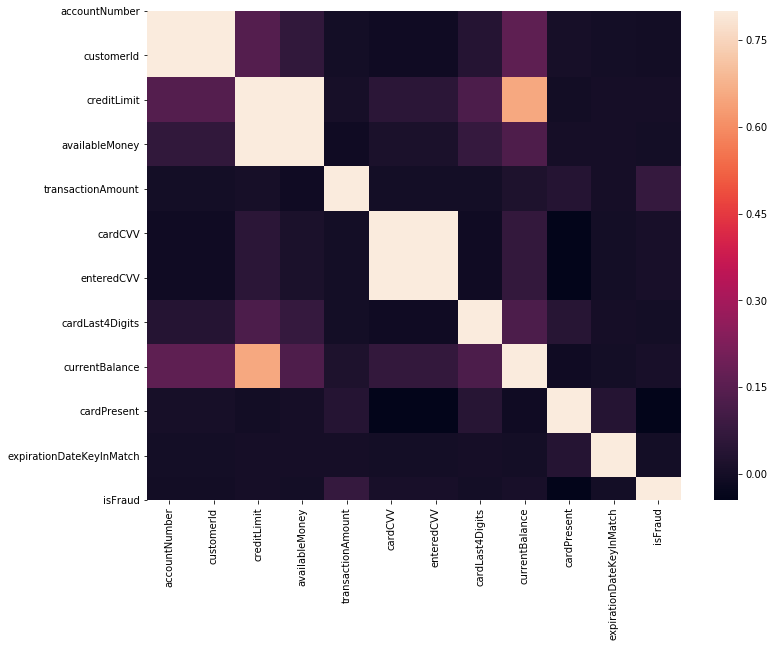

In [15]:
# Correlation matrix
corrmat = data.corr()
fig = plt.figure(figsize = (12, 9))
sns.heatmap(corrmat, vmax = .8, square = True)
plt.show()

In [16]:
# drop useless features
labels = ['transactionDateTime', 'merchantName', 'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode', 
          'merchantCategoryCode', 'currentExpDate', 'cardCVV', 'enteredCVV', 'cardLast4Digits', 'transactionType', 'echoBuffer', 'merchantCity',
          'merchantState', 'merchantZip', 'cardPresent', 'posOnPremises', 'recurringAuthInd', 'expirationDateKeyInMatch','accountOpenDate', 'dateOfLastAddressChange']
data = data.drop(labels=labels, axis=1)
data.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionAmount,currentBalance,isFraud
0,737265056,737265056,5000,5000.0,98.55,0.0,False
1,737265056,737265056,5000,5000.0,74.51,0.0,False
2,737265056,737265056,5000,5000.0,7.47,0.0,False
3,737265056,737265056,5000,5000.0,7.47,0.0,False
4,830329091,830329091,5000,5000.0,71.18,0.0,False


In [17]:
#dividing the X and the Y from the dataset
X=data.drop(['isFraud'], axis=1)
Y=data['isFraud']
print(X.shape)
print(Y.shape)
#getting just the values for the sake of processing (its a numpy array with no columns)
X_data=X.values
Y_data=Y.values

(786363, 6)
(786363,)


In [18]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size = 0.2, random_state = 42)

In [19]:
#Building another model/classifier ISOLATION FOREST
from sklearn.ensemble import IsolationForest
ifc = IsolationForest(max_samples=len(X_train),
contamination = outlier_fraction,random_state=1)
ifc.fit(X_train)
scores_pred = ifc.decision_function(X_train)
y_pred = ifc.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


In [20]:
# Reshape the prediction values to 0 for valid, 1 for fraud. 
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1
n_errors = (y_pred != Y_test).sum()

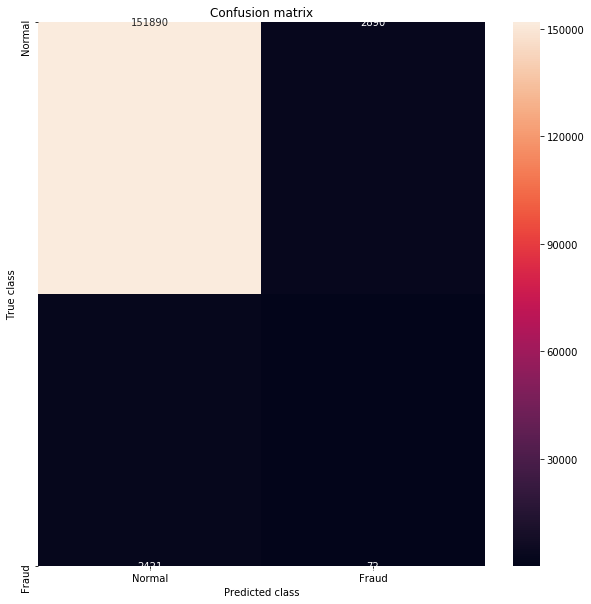

In [33]:
from sklearn.metrics import confusion_matrix
#printing the confusion matrix
LABELS = ['Normal', 'Fraud']
conf_matrix = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d');
plt.title('Confusion matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

the Model used is Isolation Forest
The accuracy is 0.9662306943976398
The precision is 0.024307900067521943
The recall is 0.02888086642599278
The F1-Score is 0.026397800183318058
The Matthews correlation coefficient is0.009380358740984411


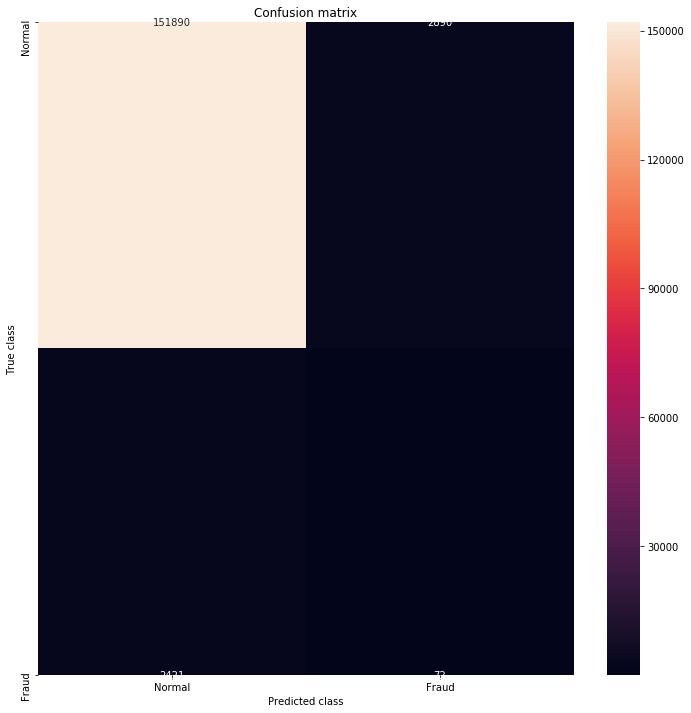

Isolation Forest: 5311
0.9662306943976398
              precision    recall  f1-score   support

       False       0.98      0.98      0.98    154780
        True       0.02      0.03      0.03      2493

    accuracy                           0.97    157273
   macro avg       0.50      0.51      0.50    157273
weighted avg       0.97      0.97      0.97    157273



<Figure size 648x504 with 0 Axes>

In [42]:
#evaluation of the model
#printing every score of the classifier
#scoring in any thing
from sklearn.metrics import *

n_outliers = len(Fraud)
print('the Model used is {}'.format('Isolation Forest'))
acc= accuracy_score(Y_test,y_pred)
print('The accuracy is {}'.format(acc))
prec= precision_score(Y_test,y_pred)
print('The precision is {}'.format(prec))
rec= recall_score(Y_test,y_pred)
print('The recall is {}'.format(rec))
f1= f1_score(Y_test,y_pred)
print('The F1-Score is {}'.format(f1))
MCC=matthews_corrcoef(Y_test,y_pred)
print('The Matthews correlation coefficient is{}'.format(MCC))


#printing the confusion matrix
LABELS = ['Normal', 'Fraud']
conf_matrix = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS,
            yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# Run classification metrics
plt.figure(figsize=(9, 7))
print('{}: {}'.format("Isolation Forest", n_errors))
print(accuracy_score(Y_test, y_pred))
print(classification_report(Y_test, y_pred))